In [1]:
#!pip install numpy
#!pip install sklearn

In [2]:
import numpy as np
import sklearn as skl
import os 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from scipy.signal import welch
import scipy

from scipy.stats import kurtosis
from scipy.stats import skew


C:\Users\grego\AppData\Local\Temp\ipykernel_10836\3917117947.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']


<div class=consignes> et les fichiers d'annotations:</div>

In [5]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

# Quelques fonctions utiles 

In [6]:
with open('./radars/test_labels.json') as f: 
    dict_labels_test = json.load(f)

Nous avons besoin d'un test de validation pour tester les performances de nos algorithmes. 

In [7]:
np.random.seed(0)
train_set=[]
validation_set=[]
for i in range(2000): 
    uniform = np.random.uniform()
    if uniform < 0.8:
        train_set.append(i)
    else:
        validation_set.append(i)


Fonction pour transformer un npz en df

In [8]:
def load_npz(file_path): 
    pdws = np.load(file_path)
    dates = pdws['date']
    largeurs = pdws['largeur']
    frequences=pdws['frequence']
    puissances = pdws['puissance']
    theta = pdws['theta']
    phi = pdws['phi']
    df=pd.DataFrame({'date':dates,'largeur':largeurs,'frequence':frequences,'puissance':puissances,'theta':theta,'phi':phi})
    return df

# Extraction de features et construction des ensembles : 

Etudions les features qui nous semblent pertinentes pour discriminer les signaux 'menace' des 'nonmenace'

On plotte les différentes variables les unes en fonction des autres pour voir si l'on observe des corrélations : 

C:\Users\grego\AppData\Local\Temp\ipykernel_10836\2472394124.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\grego\AppData\Local\Temp\ipykernel_10836\2472394124.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


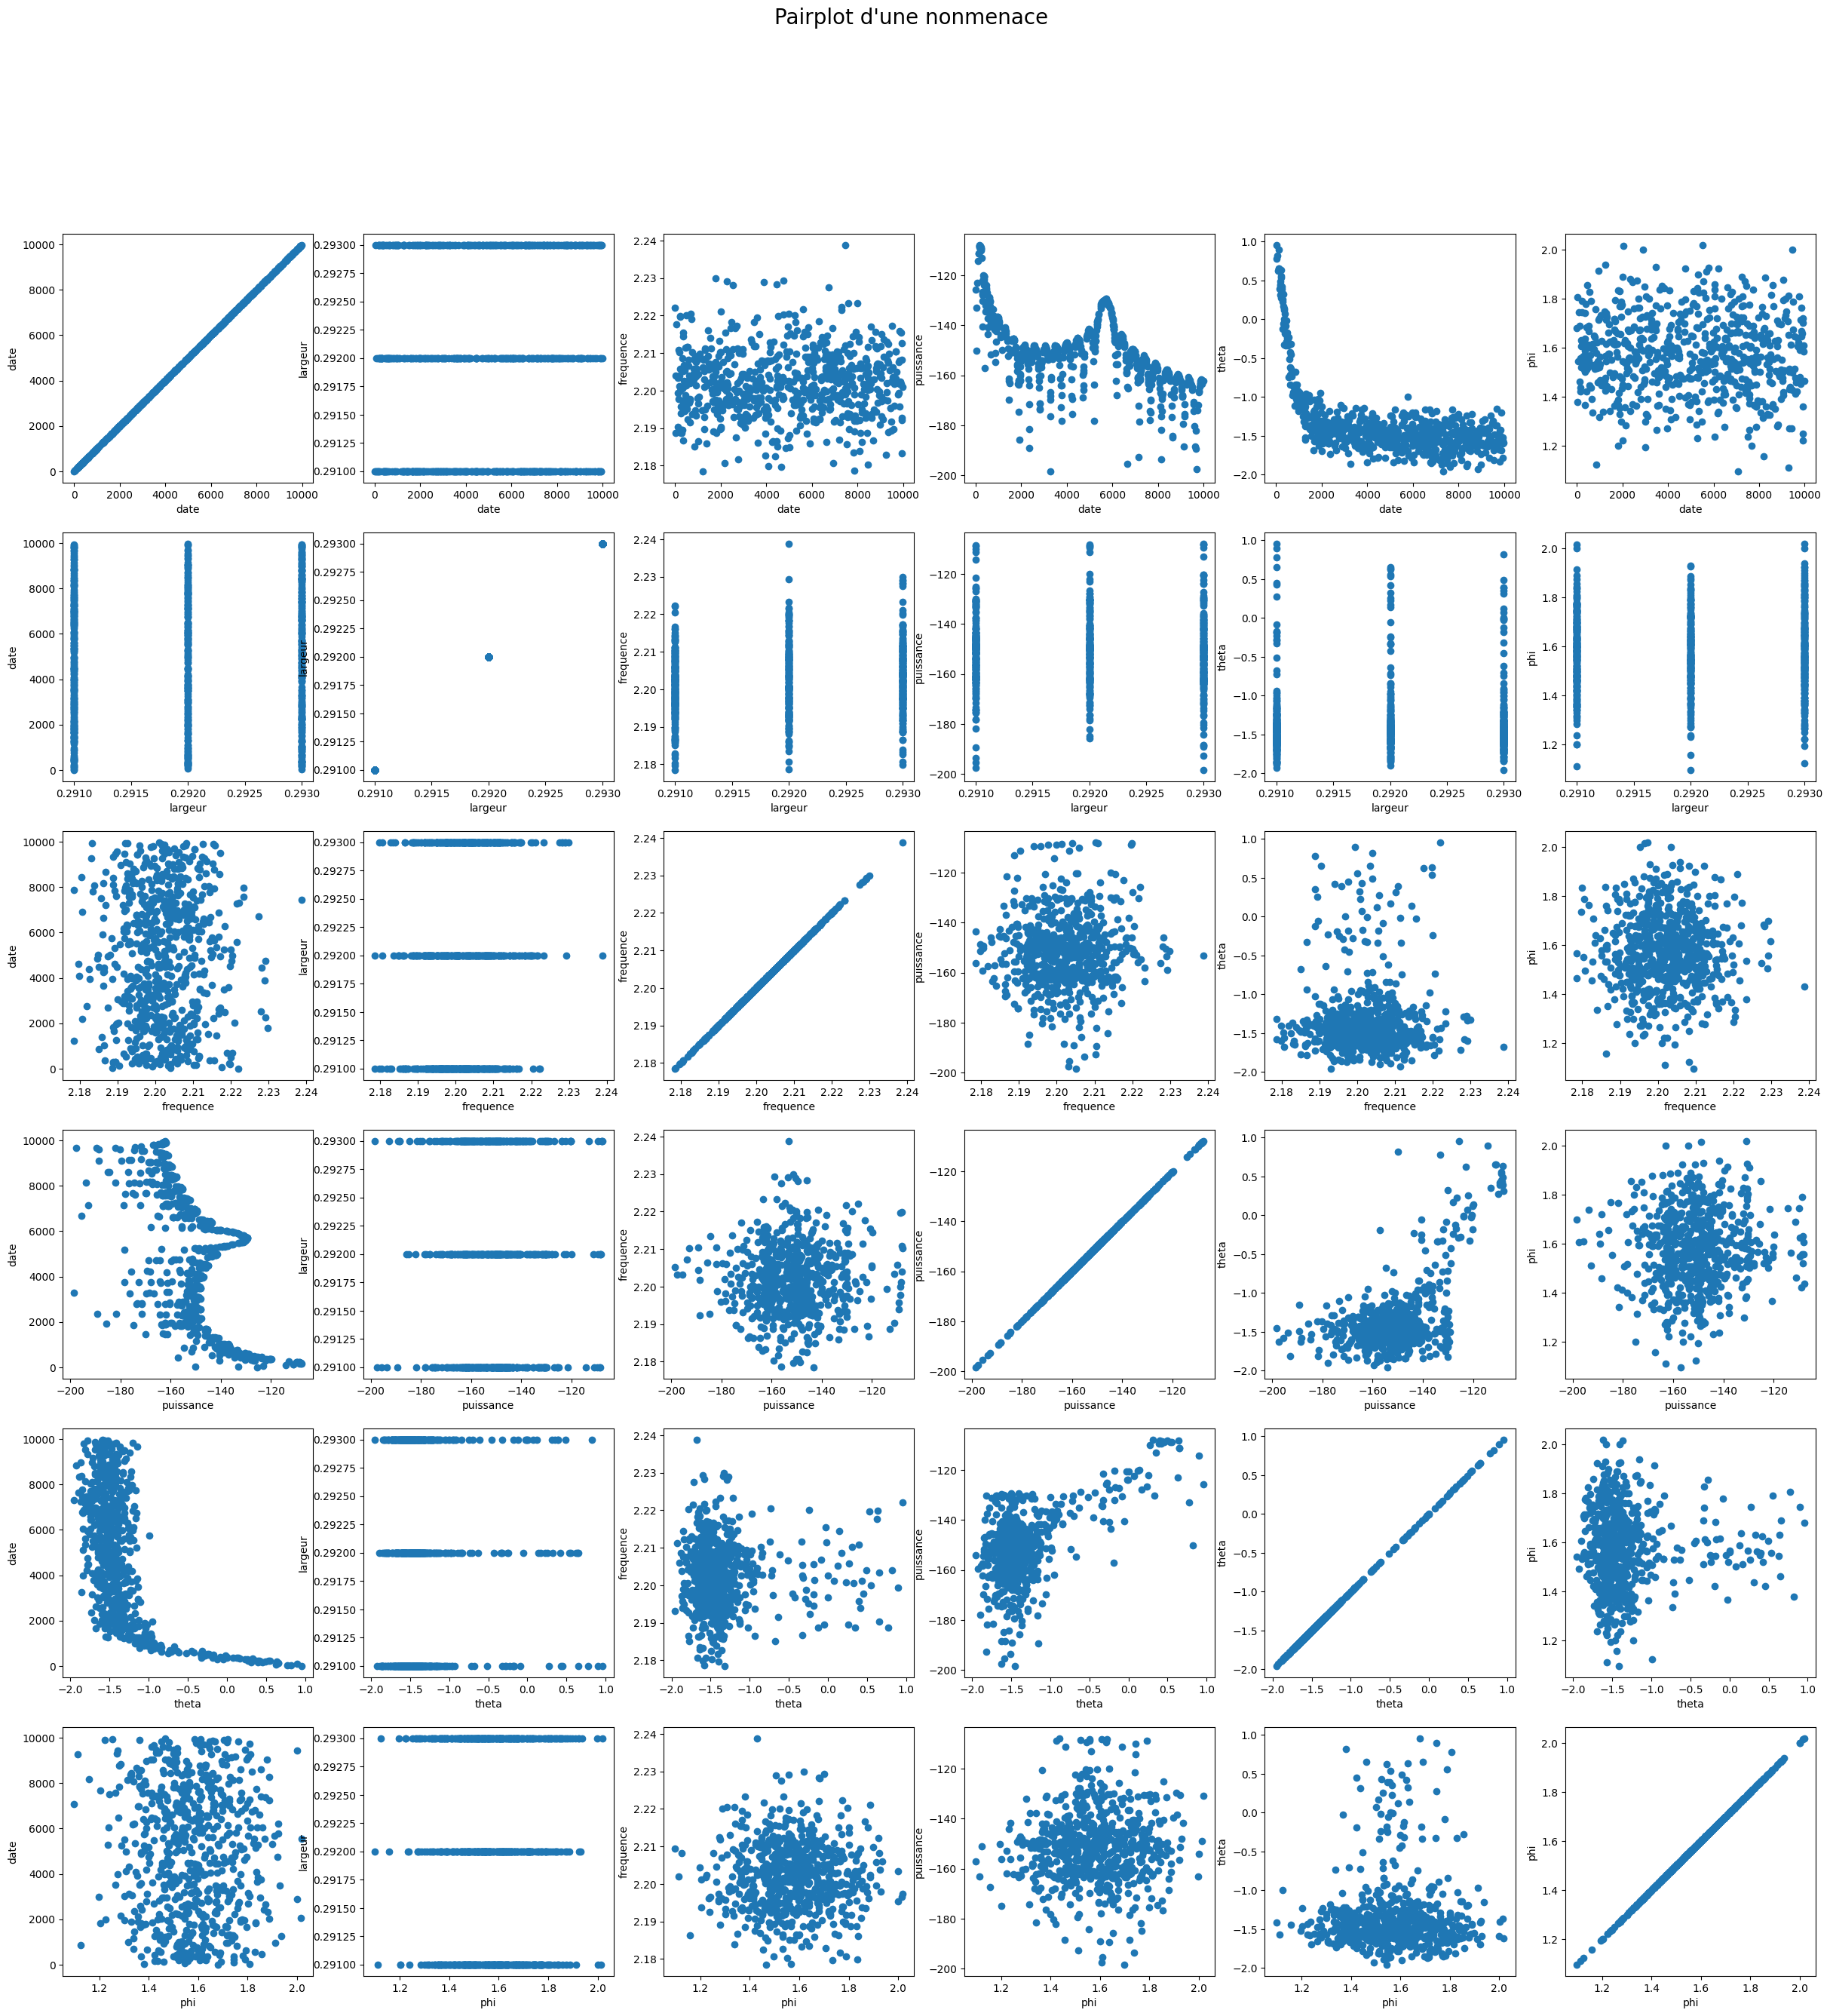

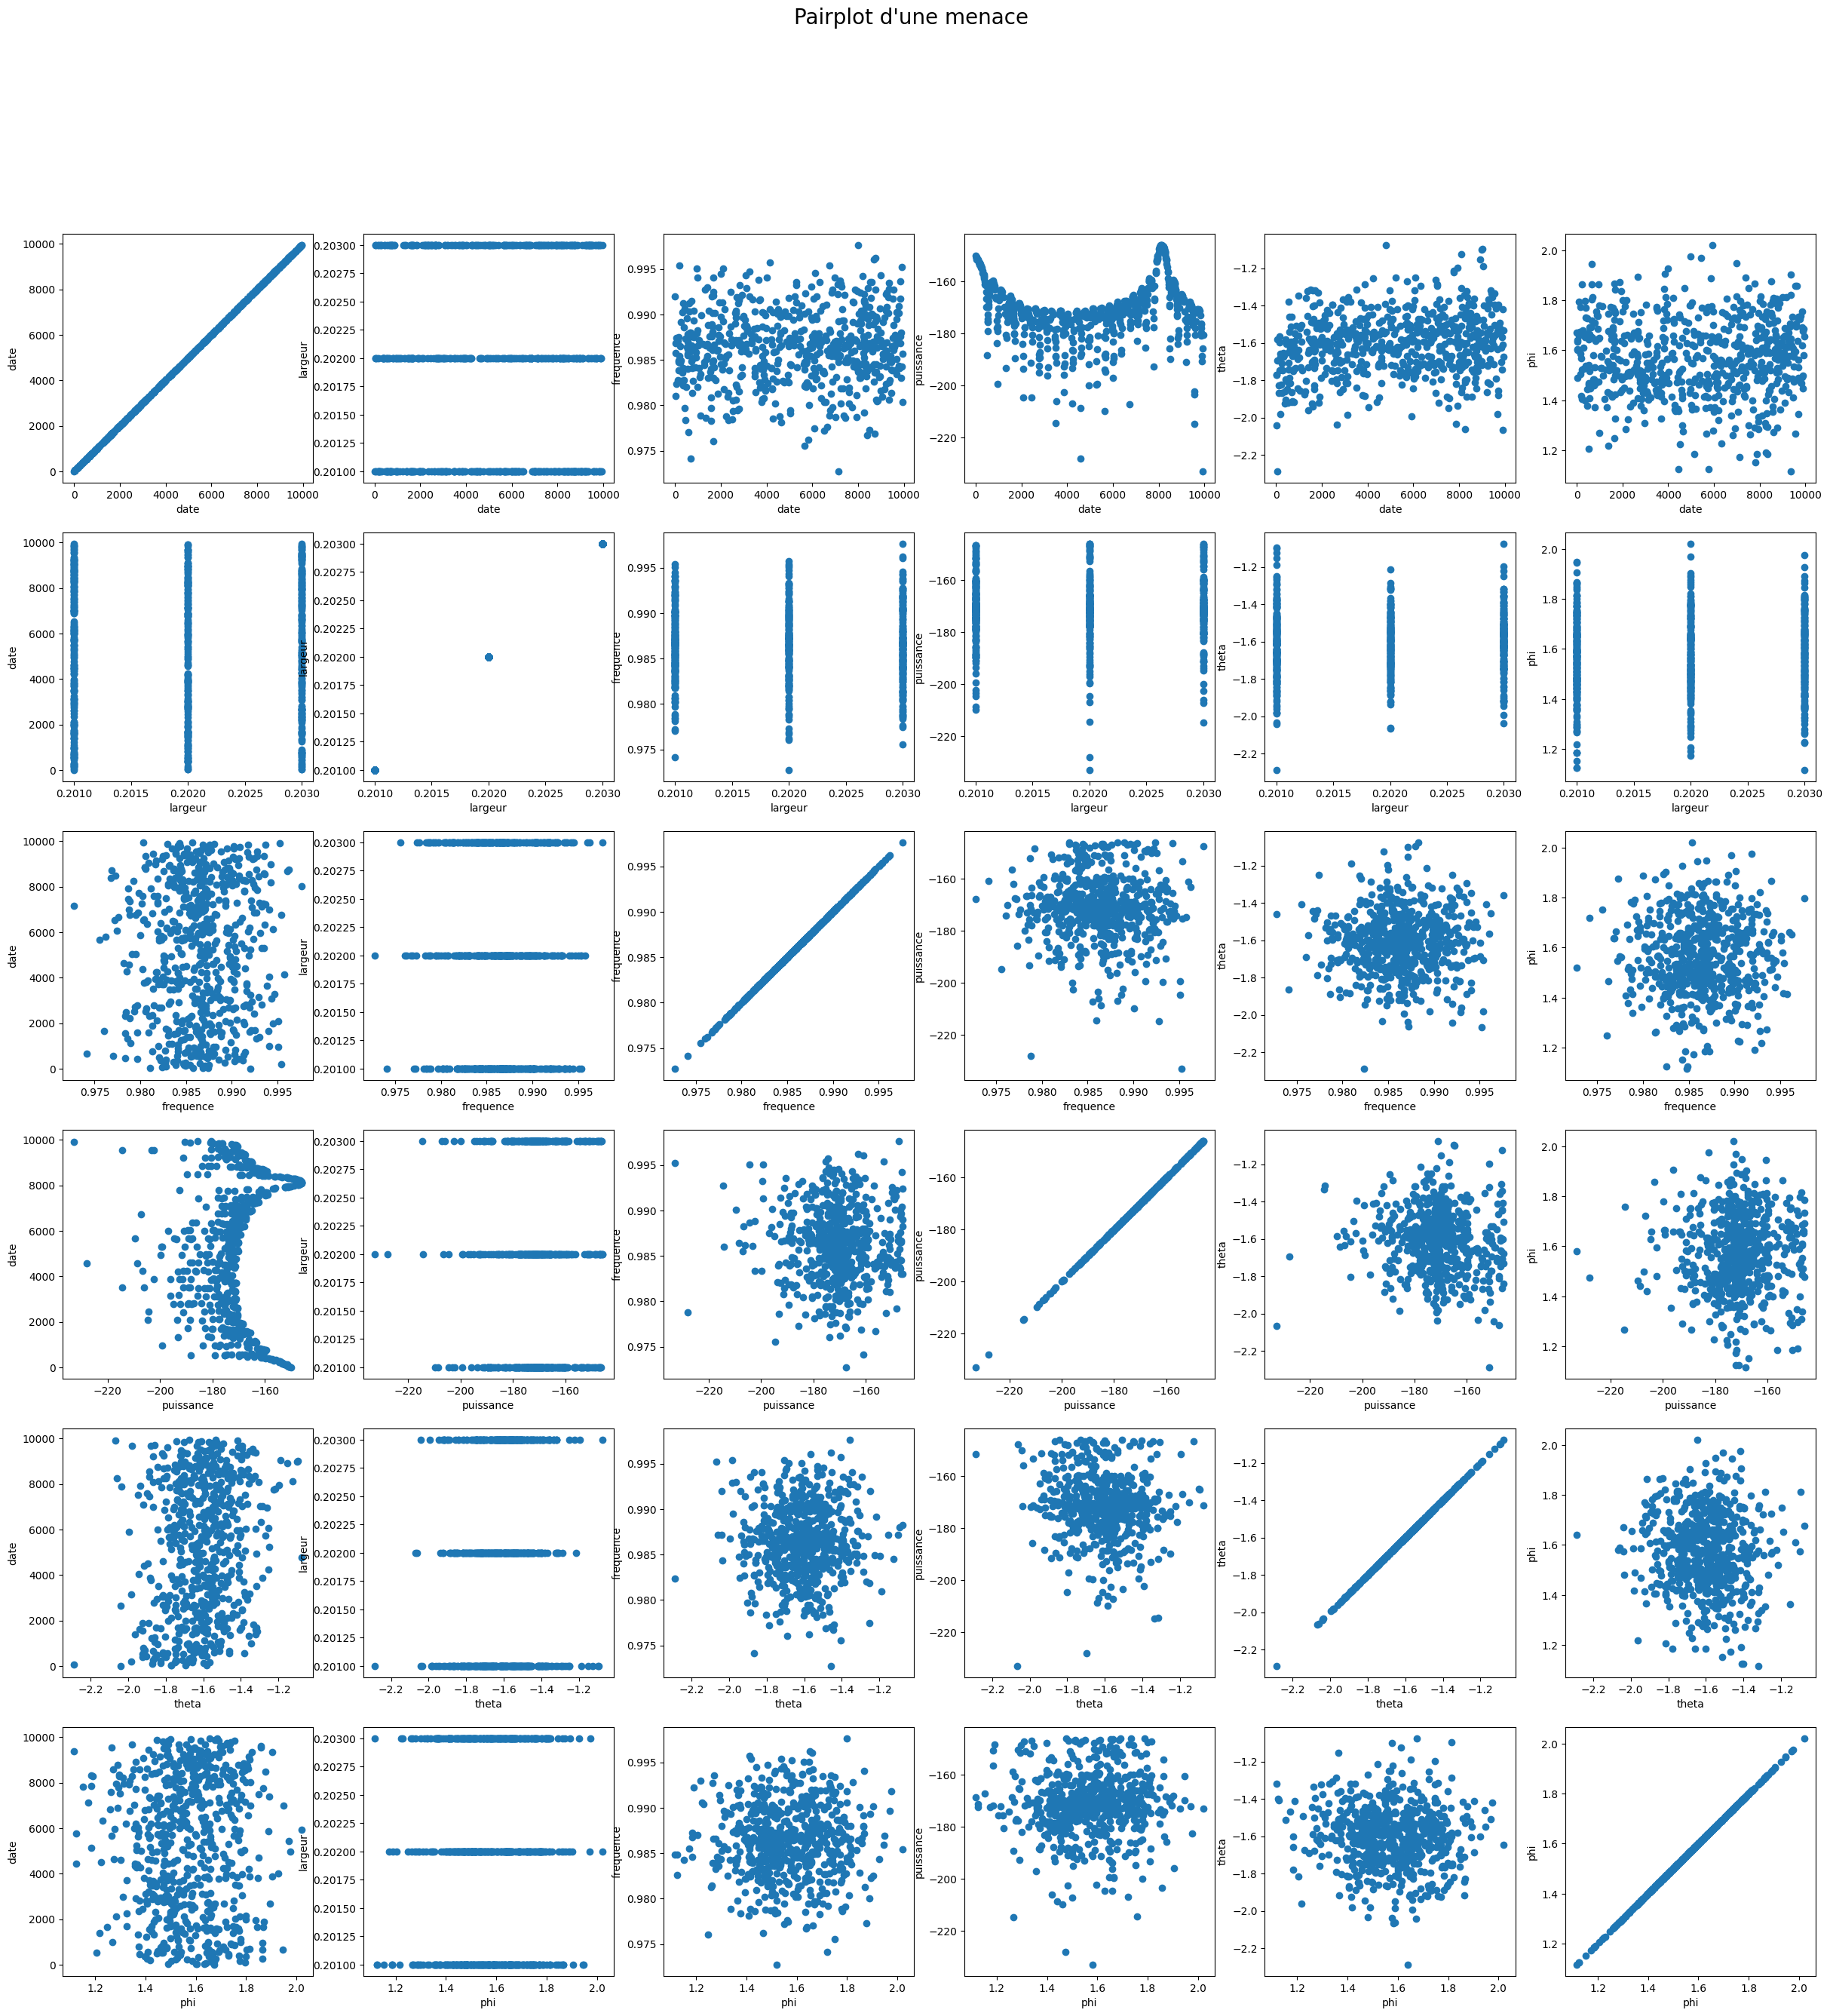

In [9]:
ex_nonmenace=load_npz('./radars/train/pdw-0.npz')
fig, ax = plt.subplots(6,6, figsize=(30,30))
for i in range(6): 
    for j in range(6): 
        c1=ex_nonmenace.columns[i]
        c2=ex_nonmenace.columns[j]
        ax[i,j].plot(ex_nonmenace[c1], ex_nonmenace[c2], 'o')
        ax[i,j].set_xlabel(c1)
        ax[i,j].set_ylabel(c2)
fig.suptitle("Pairplot d'une nonmenace", fontsize=20)
fig.show()

ex_menace=load_npz('./radars/train/pdw-2.npz')
fig, ax = plt.subplots(6,6, figsize=(30,30))
for i in range(6): 
    for j in range(6): 
        c1=ex_menace.columns[i]
        c2=ex_menace.columns[j]
        ax[i,j].plot(ex_menace[c1], ex_menace[c2], 'o')
        ax[i,j].set_xlabel(c1)
        ax[i,j].set_ylabel(c2)
fig.suptitle("Pairplot d'une menace", fontsize=20)
fig.show()


On observe plusieurs chose: aucune tendance particulière ne semble se détacher des plots croisés, à part pour: 

- $\theta$ : on semble voir une évolution se stabilisant sur une tendance pour certains signaux. Une régression linéaire sur cette tendance pourrait donner des informations 
- Largeur: elle ne semble prendre que 3 points, et cela vient sûrement d'une question d'échantillonage. Seule la valeur centrale a donc de l'importance. 
- Puissance: il s'agit de la seule variable présentant des motifs périodiques, dont l'analyse spectrale pourrait apporter de l'information. 

On a besoin de fonctions qui prennent en input un un df et retourne une ou plusieurs features

In [10]:
def get_means(df): 
    return pd.Series({'mean_date':np.mean(df['date']),'largeur': np.median(df['largeur']), 'mean_frequence':np.mean(df['frequence']),'mean_puissance':np.mean(df['puissance']),'mean_theta':np.mean(df['theta']),'mean_phi':np.mean(df['phi'])})

def get_quantiles (df):
    q1_date, q2_date = scipy.stats.mstats.mquantiles(df['date'], [0.25, 0.75])
    q1_frequence, q2_frequence = scipy.stats.mstats.mquantiles(df['frequence'], [0.25, 0.75])
    q1_theta, q2_theta = scipy.stats.mstats.mquantiles(df['theta'], [0.25, 0.75])
    q1_phi, q2_phi = scipy.stats.mstats.mquantiles(df['phi'], [0.25, 0.75])
    return pd.Series({'quantile_025_date': q1_date, 'quantile_075_date': q2_date, 'quantile_025_frequence': q1_frequence, 'quantile_075_frequence': q2_frequence, 'quantile_025_theta': q1_theta, 'quantile_075_theta': q2_theta, 'quantile_025_phi': q1_phi, 'quantile_075_phi': q2_phi})

def get_std(df): 
    return pd.Series({'std_date':np.std(df['date']),'std_frequence':np.std(df['frequence']),'std_puissance':np.std(df['puissance']),'std_theta':np.std(df['theta']),'std_phi':np.std(df['phi'])})

def get_kurtosis(df): 
    return pd.Series({'kurtosis_date':kurtosis(df['date']),'kurtosis_frequence':kurtosis(df['frequence']),'kurtosis_puissance':kurtosis(df['puissance']),'kurtosis_theta':kurtosis(df['theta']),'kurtosis_phi':kurtosis(df['phi'])})


def get_skew(df):
    return pd.Series({'skew_date':skew(df['date']),'skew_frequence':skew(df['frequence']),'skew_puissance':skew(df['puissance']),'skew_theta':skew(df['theta']),'skew_phi':skew(df['phi'])})


def reg_lin_theta(df):
    theta_permanent=df['theta'][int(0.2*len(df['theta'])):]
    X=np.arange(len(theta_permanent)).reshape(-1,1)
    y=theta_permanent
    reg=np.polyfit(X.flatten(), y, 1)
    a, b = reg
    return pd.Series({'a_reg_lin_theta':a, 'b_reg_lin_theta':b})


def Pxx_0_30(df): 
    dates=np.array(df['date'])
    puissances=np.array(df['puissance'])
    temps=np.arange(dates[0], dates[-1], 0.01)
    puiss_interp=np.interp(temps, dates, puissances)
    _, Pxx = welch(puiss_interp, fs=50, nperseg=128)
    return pd.Series({f'Pxx_{i}':Pxx[i] for i in range(len(Pxx[:30]))})


def maxs_pxx_0_30(df): 
    dates=np.array(df['date'])
    puissances=np.array(df['puissance'])
    temps=np.arange(dates[0], dates[-1], 0.01)
    puiss_interp=np.interp(temps, dates, puissances)
    _, Pxx = welch(puiss_interp, fs=50, nperseg=128)
    Pxx=Pxx/abs(Pxx)
    return  pd.Series({'max_pxx' : np.max(Pxx)})

def nombre_de_points(df): 
    return pd.Series({'nombre de points' : len(np.array(df['date']))})

    

In [11]:
def build_train_set(list_of_feature_extraction_functions): 
    X_train = []
    y_train = []
    for i in train_set: 
        file_path = f'./radars/train/pdw-{i}.npz'
        df = load_npz(file_path)
        features = pd.Series({'test':7})
        for function in list_of_feature_extraction_functions: 
            
            serie=function(df)
            features = pd.concat([features, serie])
        X_train.append(features)
        if dict_labels[f'pdw-{i}'] == 'menace': 
            lab=1
        else : 
            lab=0
        y_train.append(lab)
    X_train = pd.DataFrame(X_train)
    X_train.drop(columns=['test'],inplace=True)
    y_train = np.array(y_train)

    return X_train, y_train


def build_final_train_set(list_of_feature_extraction_functions):
    X_train = []
    y_train = []

    for i in train_set+validation_set: 
        file_path = f'./radars/train/pdw-{i}.npz'
        df = load_npz(file_path)
        features = pd.Series({'test':7})
        for function in list_of_feature_extraction_functions: 
            
            serie=function(df)
            features = pd.concat([features, serie])
        X_train.append(features)
        if dict_labels[f'pdw-{i}'] == 'menace': 
            lab=1
        else : 
            lab=0
        y_train.append(lab)
    X_train = pd.DataFrame(X_train)
    X_train.drop(columns=['test'],inplace=True)
    y_train = np.array(y_train)

    return X_train, y_train


def build_validation_set(list_of_feature_extraction_functions): 
    X_val = []
    y_val = []
    for i in validation_set: 
        file_path = f'./radars/train/pdw-{i}.npz'
        df = load_npz(file_path)
        features = pd.Series({'test':7})
        for function in list_of_feature_extraction_functions: 
            
            serie=function(df)
            features = pd.concat([features, serie])
        X_val.append(features)
        if dict_labels[f'pdw-{i}'] == 'menace': 
            lab=1
        else : 
            lab=0
        y_val.append(lab)
    X_val = pd.DataFrame(X_val)
    X_val.drop(columns=['test'],inplace=True)
    y_val = np.array(y_val)

    return X_val, y_val

def build_test_set(list_of_feature_extraction_functions):
    X_test = []
    y_test = []
    for i in range(100): 
        file_path = f'./radars/test/pdw-{i}.npz'
        df = load_npz(file_path)
        features = pd.Series({'test':7})
        for function in list_of_feature_extraction_functions: 
            serie=function(df)
            features = pd.concat([features, serie])
        X_test.append(features)
        if dict_labels_test[f'pdw-{i}'] == 'menace': 
            lab=1
        else : 
            lab=0
        y_test.append(lab)
    X_test = pd.DataFrame(X_test)
    X_test.drop(columns=['test'],inplace=True)
    y_test = np.array(y_test)

    return X_test, y_test


In [12]:
X_train, y_train=build_train_set([get_means, get_std, get_kurtosis, get_skew])
X_val, y_val=build_validation_set([get_means, get_std, get_kurtosis, get_skew])

Maintenant on peut tester d'entraîner un modèle sur un X_train construit avec certaines features 

In [13]:
def train_model(model,  X_train, y_train): # entrainement de notre modèle sur un dataset fait de certaines features
    model.fit(X_train, y_train)
    return model

In [14]:
def predictions(model_trained, list_of_feature_extraction_functions, X_val):  # on prédit les labels de notre dataset de validation
    X_val, y_val = build_validation_set(list_of_feature_extraction_functions)
    y_pred = model_trained.predict(X_val)
    return y_pred

In [15]:
def compute_confusion_matrix(y_val, y_pred): 
    return confusion_matrix(y_val, y_pred)

In [16]:
def compute_precision_recall(y_pred, y_val): # takes 2 arrays as an input and returns precision and recall
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    return precision, recall

In [17]:
def evaluate_perf(list_of_feature_extraction_functions, model, X_train, y_train, X_val, y_val):
    model_trained = train_model(model,  X_train, y_train)
    y_pred = predictions(model_trained, list_of_feature_extraction_functions, X_val)
    precision, recall = compute_precision_recall(y_pred, y_val)
    acc = 0 
    y_val=np.array(y_val).flatten()
    y_pred=np.array(y_pred).flatten()
    for i in range(len(y_val)): 
        if y_val[i] == y_pred[i]:
            acc+=1
    acc = acc/len(y_val)
    return {'confusion matrix' : confusion_matrix(y_val, y_pred), 'precision': precision, 'recall':  recall, 'accuracy': acc}

# Test sur différents algos de ML : 

Construction des ensembles d'entrainement et de validation : 

In [18]:
features_list=[get_means, get_std, get_kurtosis, get_skew, reg_lin_theta, Pxx_0_30, maxs_pxx_0_30, nombre_de_points, get_quantiles]

In [19]:
X_val, y_val = build_validation_set(features_list)
X_train, y_train = build_train_set(features_list)

Notre algo de baseline sera un Random Forest entraîné sur les moyennes

In [20]:
rf=RandomForestClassifier(n_estimators=100, random_state=42)
features_list_dummy=[get_means]
X_val_baseline, y_val_baseline = build_validation_set(features_list_dummy)
X_train_baseline, y_train_baseline = build_train_set(features_list_dummy)
evaluate_perf(features_list_dummy, rf, X_train_baseline, y_train_baseline, X_val_baseline, y_val_baseline )

{'confusion matrix': array([[164,  51],
        [ 63, 150]], dtype=int64),
 'precision': 0.746268656716418,
 'recall': 0.704225352112676,
 'accuracy': 0.7336448598130841}

In [31]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)


Some results : 

In [33]:
for n_estimator in [10, 50, 100, 200, 500]: 
    for max_depth in [2, 3, 4]: 
        rf=RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=42)
        gb=GradientBoostingClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=42)
        res_gb=evaluate_perf(features_list, gb, X_train, y_train, X_val, y_val)
        res_rf=evaluate_perf(features_list, rf, X_train, y_train, X_val, y_val)
        res_gb_scaled=evaluate_perf(features_list, gb, X_train_scaled, y_train, X_val_scaled, y_val)
        res_rf_scaled=evaluate_perf(features_list, rf, X_train_scaled, y_train, X_val_scaled, y_val)
        with open('results.txt', 'a') as f: 
            f.write(f"n_estimators: {n_estimator}, max_depth: {max_depth}, res_gb: {res_gb}, res_rf: {res_rf}, res_gb_scaled: {res_gb_scaled}, res_rf_scaled: {res_rf_scaled}\n")


Le meilleur modèle est : 

In [29]:
model = ''

On l'entraine sur tout le train set avant de le tester sur le test set: 

In [ ]:
X_train_final, y_train_final = build_final_train_set(features_list)
X_test, y_test = build_test_set(features_list)
evaluate_perf(features_list, model, X_train_final, y_train_final, X_test, y_test)

LA SUITE C EST DU BROUILLON 

idées : 

skew 

kurtosis 


analyse de fréquence ? max de la FFT ? si ya une périodicité des signaux = menace ? même question avec autocorrélation ? 

bande d'énergie dans la fft (plus adaptable poru un vrai signal)


Sélection de features : faire la matrice de corrélation des features puis faire un dendogram pour ne récupérer que les représentants de chacun des cluster 

Eliminer les features dont la variance est très faible 

regarder quels fatures ont une grosse corrélation avec les labels 

# Sélction de features : 

On construit un train set avec toutes les features et on élimine celles qui ne semblent pas d'intérêt: 

In [ ]:
features_func=[get_means, get_std, get_kurtosis, get_skew, reg_lin_theta, Pxx_0_30]

In [ ]:
X_train, y_train = build_train_set(features_func)

In [ ]:
X_train.head()

mean_date  mean_largeur  mean_frequence  mean_puissance  mean_theta  \
0  4888.973045      0.292003        2.202149     -151.168286   -1.334458   
1  5067.896401      0.137017        2.996037     -152.733649   -1.634125   
2  5204.953813      0.201962        0.986435     -171.253159   -1.607840   
3  4918.404864      0.069014        1.665592     -149.829714   -1.690380   
4  5137.395809      0.324018        2.205039     -177.214144   -1.559266   

   mean_phi     std_date  std_largeur  std_frequence  std_puissance  ...  \
0  1.574437  2857.596749     0.000829       0.008909      14.271022  ...   
1  1.570940  2828.806021     0.000810       0.012328      11.655734  ...   
2  1.571787  2964.096678     0.000824       0.004003      12.164566  ...   
3  1.585633  2838.130272     0.000813       0.006610       9.564745  ...   
4  1.578277  2866.851023     0.000813       0.008529      11.162828  ...   

         Pxx_20        Pxx_21        Pxx_22        Pxx_23        Pxx_24  \
0  1.255115e-09  9.862141e-10  8.308563e-10  6.771482e-10  5.606087e-10   
1  2.154940e-09  1.753963e-09  1.463627e-09  1.197953e-09  1.029157e-09   
2  4.110945e-09  3.104595e-09  2.571050e-09  2.271550e-09  1.711231e-09   
3  3.765472e-09  2.883038e-09  2.504022e-09  2.050179e-09  1.707824e-09   
4  5.392518e-10  4.270689e-10  3.575275e-10  2.936049e-10  2.463633e-10   

         Pxx_25        Pxx_26        Pxx_27        Pxx_28        Pxx_29  
0  4.672447e-10  3.981866e-10  3.371932e-10  2.912897e-10  2.460802e-10  
1  8.369025e-10  7.391825e-10  6.156999e-10  5.364745e-10  4.653685e-10  
2  1.582384e-09  1.312389e-09  1.084386e-09  9.551225e-10  8.237363e-10  
3  1.506860e-09  1.197546e-09  1.120458e-09  8.832759e-10  8.490915e-10  
4  2.023349e-10  1.744943e-10  1.488716e-10  1.275616e-10  1.096919e-10  

[5 rows x 56 columns]

In [ ]:
print('On commence avec '+str(X_train.shape[1])+' features')

On commence avec 56 features


La c'est la partie clustering, avec seulement 24 features ça n'a pas beaucoup de sens, on y reviendra quand on aura plus de features 

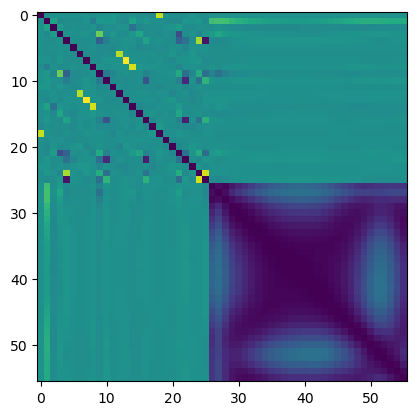

In [ ]:
#correlation matrix of the features : 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

corr = pdist(X_train.to_numpy().T, metric="correlation")  # distance matrix
plt.imshow(squareform(corr))

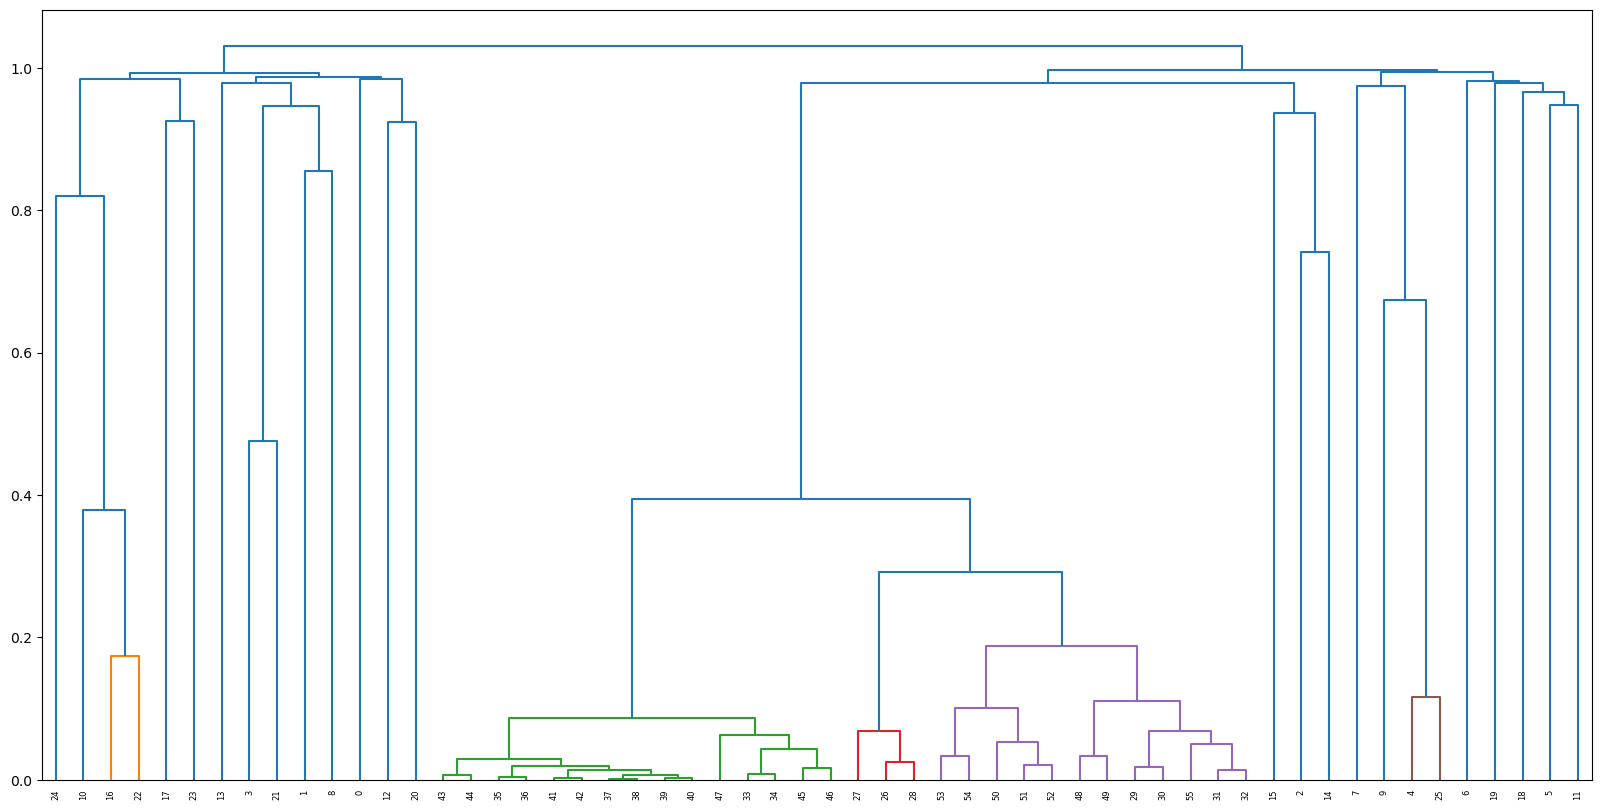

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=0.2
)

Tout d'abord, les features dont la variance est très faible n'apportent aucune information: 

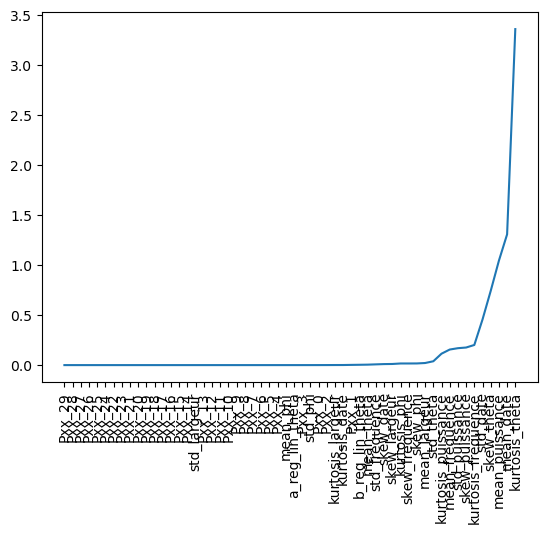

In [ ]:
vars=[(col, np.var(X_train[col])/np.max(abs(X_train[col]))) for col in X_train.columns]

vars.sort(key = lambda x: x[1])
plt.plot([vars[i][1] for i in range(len(vars))])
plt.xticks(range(len(vars)), [vars[i][0] for i in range(len(vars))], rotation=90)
plt.show()

In [ ]:

threshold = 0.01
X_train_epuré = X_train[[vars[i][0] for i in range(len(vars)) if vars[i][1] >0.01]]
X_train_epuré.head()
print('on a retiré '+str(X_train.shape[1]-X_train_epuré.shape[1])+' features')
print('il reste '+str(X_train_epuré.shape[1])+' features')

on a retiré 39 features
il reste 17 features


On retire aussi les features qui sont complètement décorrélées des labels : 

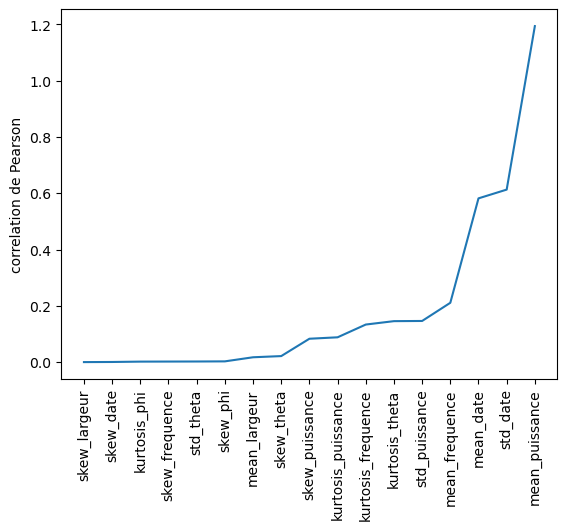

In [ ]:
coef_person = [(col, np.cov(X_train_epuré[col], y_train)[0,1] ) for col in X_train_epuré.columns]
coef_person.sort(key = lambda x: abs(x[1]))
plt.plot([abs(coef_person[i][1]) for i in range(len(coef_person))])
plt.xticks(range(len(coef_person)), [coef_person[i][0] for i in range(len(coef_person))], rotation=90)
plt.ylabel('correlation de Pearson')
plt.show()


In [ ]:
threshold_pearson = 0.01
X_train_epuré_2 = X_train_epuré[[coef_person[i][0] for i in range(len(coef_person)) if abs(coef_person[i][1]) > threshold_pearson]]
X_train_epuré_2.head()
print('on a retiré '+str(X_train_epuré.shape[1]-X_train_epuré_2.shape[1])+' features')
print('il reste '+str(X_train_epuré_2.shape[1])+' features')


on a retiré 6 features
il reste 11 features


In [385]:


compute_precision_recall(identification, real_labels)

(0.56, 1.0)

In [389]:
np.linspace(0.005, 0.015, 11)

array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013,
       0.014, 0.015])

In [421]:
a=load_npz('./radars/train/pdw-0.npz')

dates=np.array(a['date'])
puissances=np.array(a['puissance'])
temps=np.arange(dates[0], dates[-1], 0.01)
puiss_interp=np.interp(temps, dates, puissances)
f, Pxx = welch(puiss_interp, fs=50, nperseg=128)
# # plt.plot(f, Pxx)
# plt.plot(temps, puiss_interp)
# plt.title('les deux signaux')
# plt.plot(dates, puissances)
len(Pxx)

65

C:\Users\grego\AppData\Local\Temp\ipykernel_22260\1656645993.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


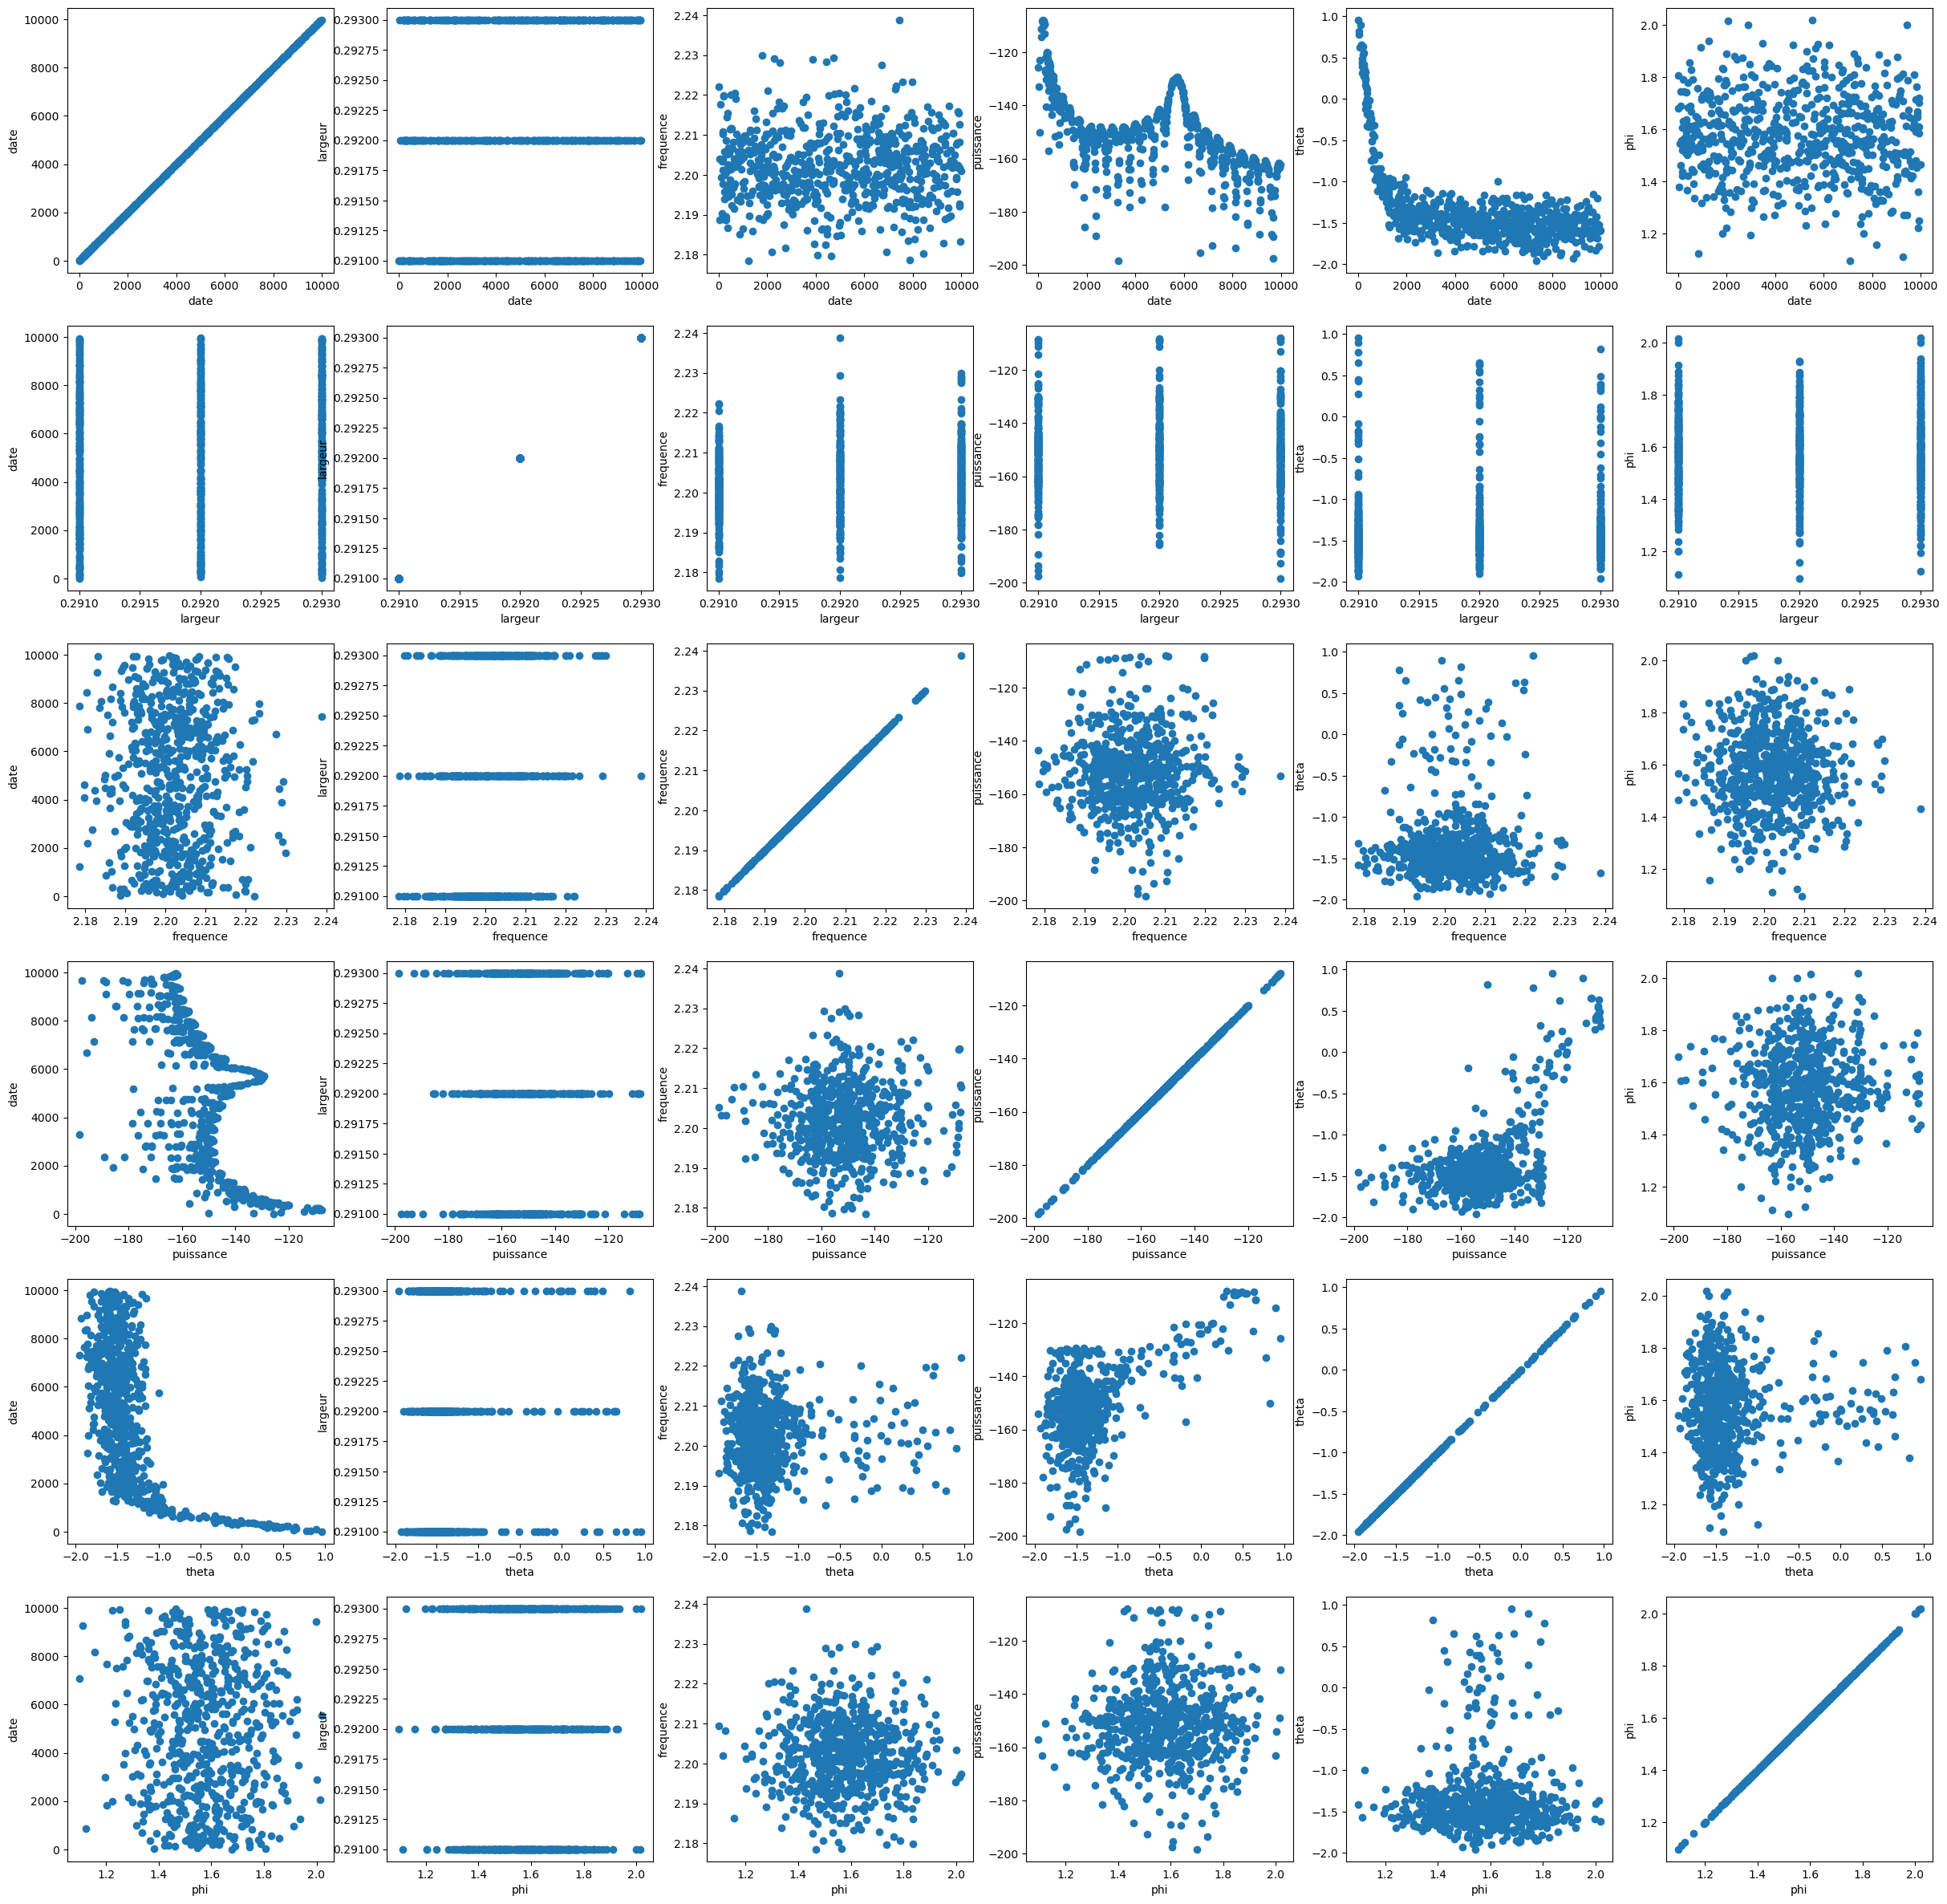

In [395]:
a=load_npz('./radars/train/pdw-0.npz')
a.head()
fig, ax = plt.subplots(6,6, figsize=(30,30))
for i in range(6): 
    for j in range(6): 
        c1=a.columns[i]
        c2=a.columns[j]
        ax[i,j].plot(a[c1], a[c2], 'o')
        ax[i,j].set_xlabel(c1)
        ax[i,j].set_ylabel(c2)
fig.show()

In [413]:
for i in range(10): 
    a=load_npz('./radars/train/pdw-'+str(i)+'.npz')
    theta_permanent=a['theta'][int(0.2*len(a['theta'])):]
    # regression lineaire sur theta: 
    X=np.arange(len(theta_permanent)).reshape(-1,1)
    y=theta_permanent
    reg=np.polyfit(X.flatten(), y, 1)
    a, b = reg
    print(a,b)




-0.0002553558400244903 -1.4312515317698502
4.629947496301164e-05 -1.6312474379082782
5.966301601982491e-05 -1.606895277546814
9.8982177540057e-05 -1.6899313152219744
5.489352617344383e-05 -1.617759190877372
-0.00027213329458548066 -1.4003294645817908
6.817473500789419e-05 -1.637834790158123
-2.9482736152954716e-05 -1.4496506378741287
-4.8407815031080006e-05 -1.5136160027922156
-5.1617982178546e-05 -1.4740851579635221


# Feature selection : 

On construit un train set avec toutes les features et on élimine celles qui ne semblent pas d'intérêt: 

In [ ]:
features_func=[extract_mean_dates, extract_mean_largeurs, extract_mean_frequences, extract_mean_puissances, extract_mean_theta, extract_mean_phi, extract_std_dates, extract_std_largeurs, extract_std_frequences, extract_std_puissances, extract_std_theta, extract_std_phi, extract_skew_date, extract_skew_largeur, extract_skew_frequence, extract_skew_puissance, extract_skew_theta, extract_skew_phi, extract_kurtosis_date, extract_kurtosis_largeur, extract_kurtosis_frequence, extract_kurtosis_puissance, extract_kurtosis_theta, extract_kurtosis_phi]

In [ ]:
X_train, y_train = build_train_set(features_func)

In [ ]:
X_train.head()


mean_dates  mean_largeurs  mean_frequences  mean_puissances  mean_theta  \
0  4888.973045       0.292003         2.202149      -151.168286   -1.334458   
1  5067.896401       0.137017         2.996037      -152.733649   -1.634125   
2  5204.953813       0.201962         0.986435      -171.253159   -1.607840   
3  4918.404864       0.069014         1.665592      -149.829714   -1.690380   
4  5137.395809       0.324018         2.205039      -177.214144   -1.559266   

   mean_phi    std_dates  std_largeurs  std_frequences  std_puissances  ...  \
0  1.574437  2859.725313      0.000830        0.008915       14.281652  ...   
1  1.570940  2830.115350      0.000811        0.012333       11.661129  ...   
2  1.571787  2966.433373      0.000825        0.004006       12.174156  ...   
3  1.585633  2839.117620      0.000813        0.006612        9.568072  ...   
4  1.578277  2869.219343      0.000814        0.008536       11.172050  ...   

   skew_frequence  skew_puissance  skew_theta  skew_phi  kurtosis_date  \
0        0.258678        0.217083    2.553388 -0.002874      -1.190320   
1       -0.176506       -0.638058    8.303660 -0.095534      -1.209930   
2       -0.109666       -0.640074   -0.048184 -0.106081      -1.279158   
3        0.071322       -0.665002   -0.799275 -0.033084      -1.160659   
4        0.110156       -0.341343    4.993394 -0.120520      -1.165211   

   kurtosis_largeur  kurtosis_frequence  kurtosis_puissance  kurtosis_theta  \
0         -1.545415            0.494590            1.139497        6.884833   
1         -1.476217           -0.073434            1.115002      114.412113   
2         -1.523660            0.003984            2.238964        0.582369   
3         -1.485445            0.098843            1.905150        1.397115   
4         -1.487295           -0.334689            1.741741       28.125890   

   kurtosis_phi  
0     -0.054921  
1      0.283584  
2     -0.055838  
3      0.251948  
4      0.694534  

[5 rows x 24 columns]

In [ ]:
print('On commence avec '+str(X_train.shape[1])+' features')

On commence avec 24 features


La c'est la partie clustering, avec seulement 24 features ça n'a pas beaucoup de sens, on y reviendra quand on aura plus de features 

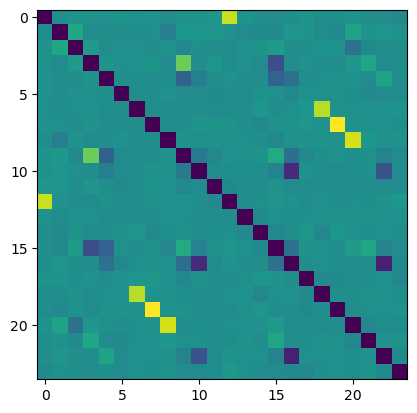

In [ ]:
#correlation matrix of the features : 
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

corr = pdist(X_train.to_numpy().T, metric="correlation")  # distance matrix
plt.imshow(squareform(corr))

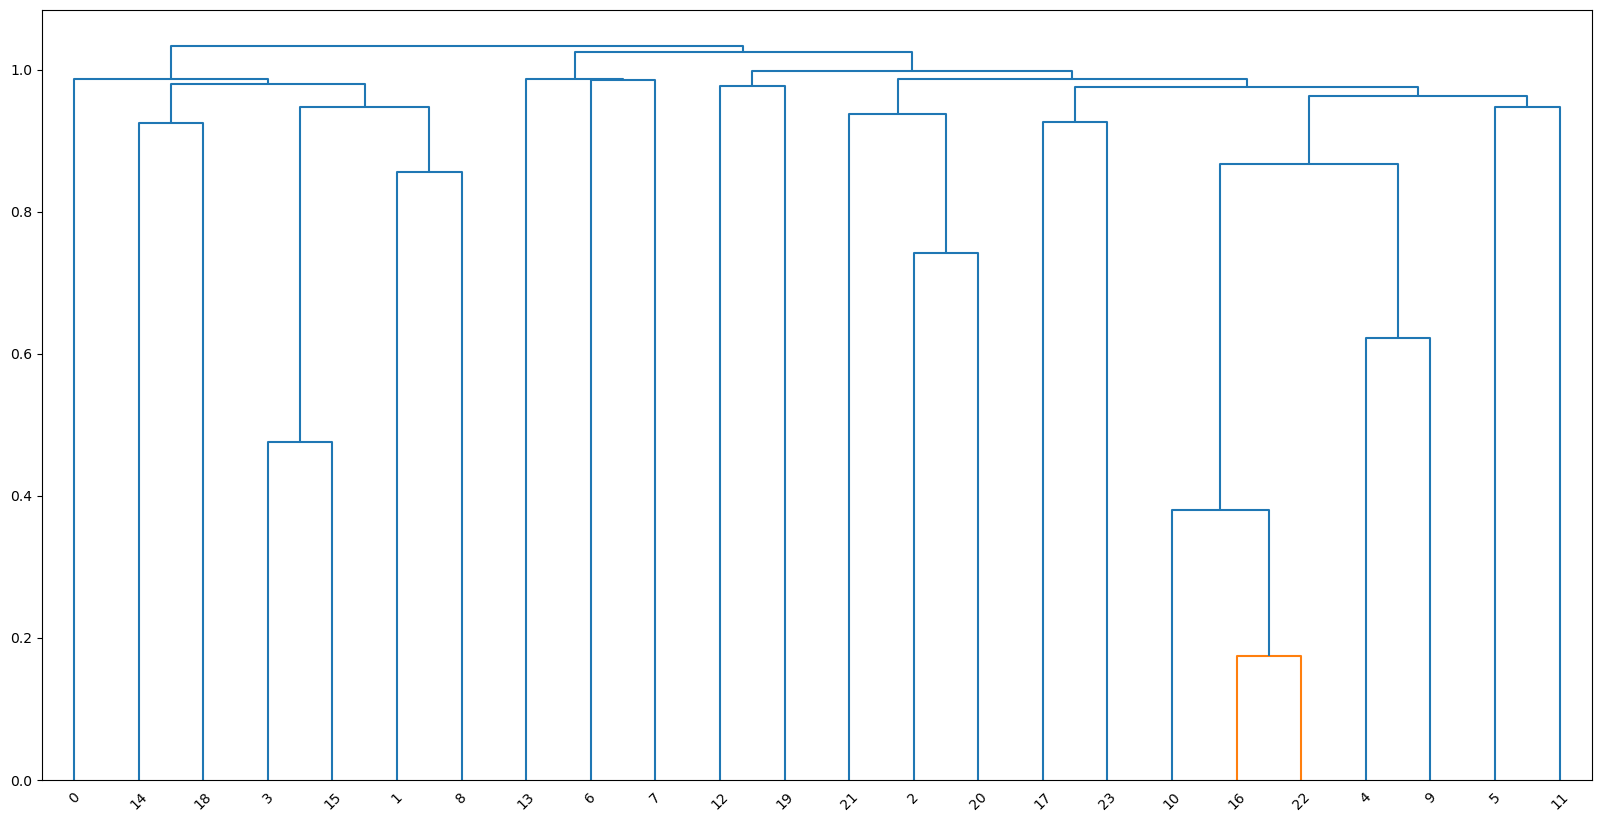

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=0.2
)

Tout d'abord, les features dont la variance est très faible n'apportent aucune information: 

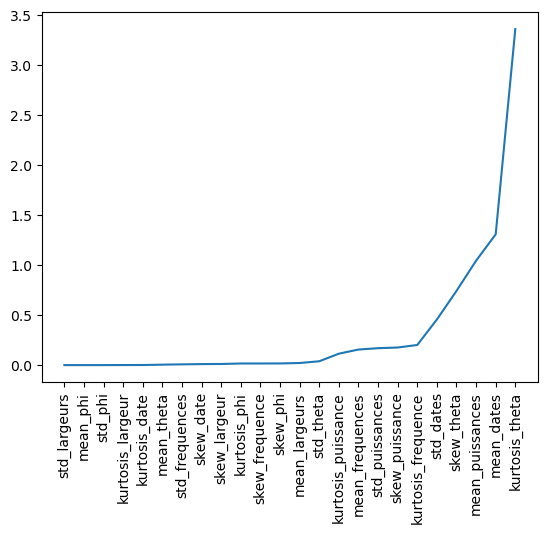

In [ ]:
vars=[(col, np.var(X_train[col])/np.max(abs(X_train[col]))) for col in X_train.columns]

vars.sort(key = lambda x: x[1])
plt.plot([vars[i][1] for i in range(len(vars))])
plt.xticks(range(len(vars)), [vars[i][0] for i in range(len(vars))], rotation=90)
plt.show()

In [ ]:

threshold = 0.01
X_train_epuré = X_train[[vars[i][0] for i in range(len(vars)) if vars[i][1] >0.01]]
X_train_epuré.head()
print('on a retiré '+str(X_train.shape[1]-X_train_epuré.shape[1])+' features')
print('il reste '+str(X_train_epuré.shape[1])+' features')

on a retiré 7 features
il reste 17 features


On retire aussi les features qui sont complètement décorrélées des labels : 

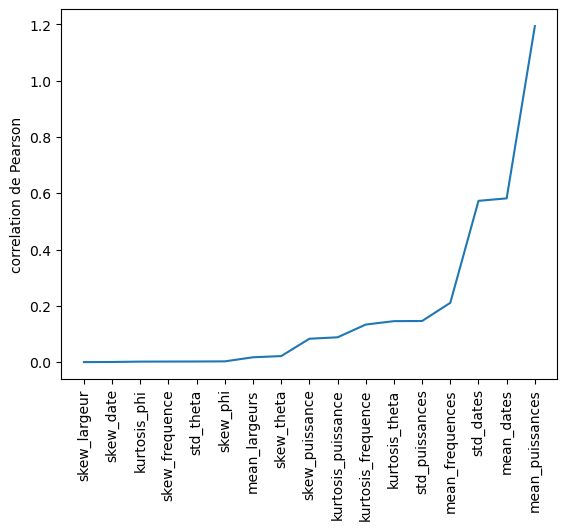

In [ ]:
coef_person = [(col, np.cov(X_train_epuré[col], y_train)[0,1] ) for col in X_train_epuré.columns]
coef_person.sort(key = lambda x: abs(x[1]))
plt.plot([abs(coef_person[i][1]) for i in range(len(coef_person))])
plt.xticks(range(len(coef_person)), [coef_person[i][0] for i in range(len(coef_person))], rotation=90)
plt.ylabel('correlation de Pearson')
plt.show()


In [ ]:
threshold_pearson = 0.01
X_train_epuré_2 = X_train_epuré[[coef_person[i][0] for i in range(len(coef_person)) if abs(coef_person[i][1]) > threshold_pearson]]
X_train_epuré_2.head()
print('on a retiré '+str(X_train_epuré.shape[1]-X_train_epuré_2.shape[1])+' features')
print('il reste '+str(X_train_epuré_2.shape[1])+' features')


on a retiré 6 features
il reste 11 features


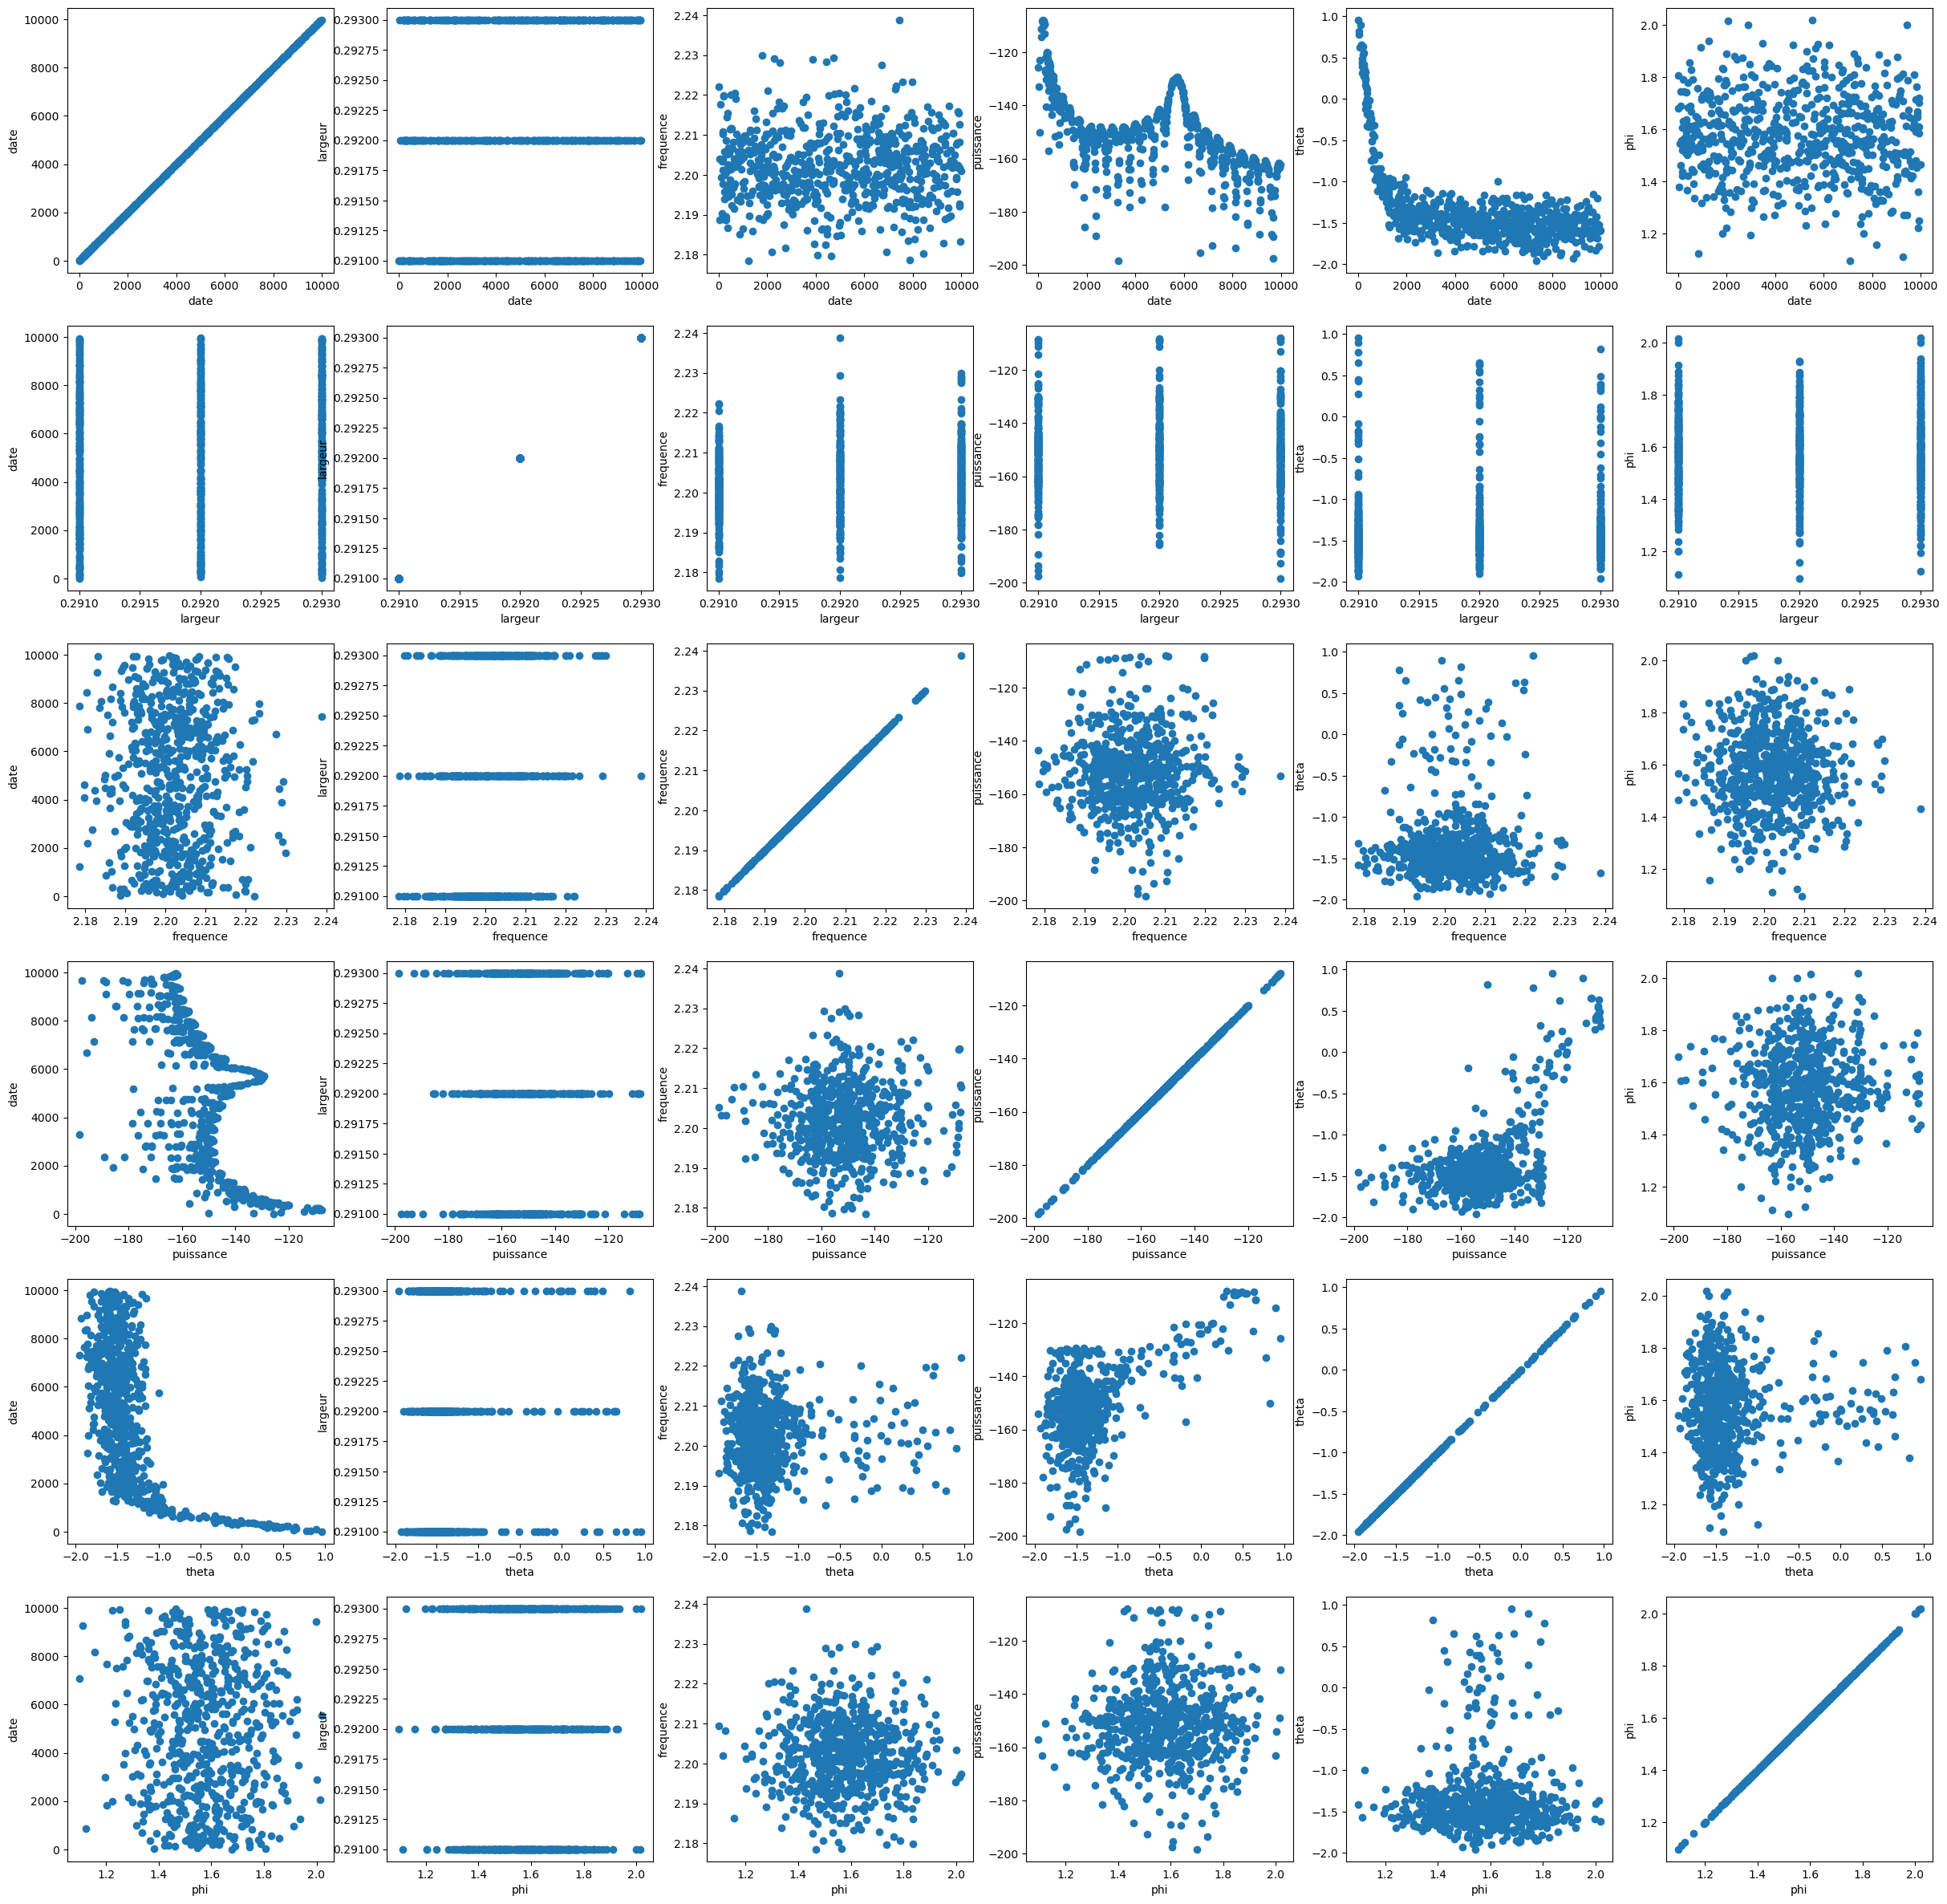

In [343]:
a=load_npz('./radars/train/pdw-0.npz')
a.head()
fig, ax = plt.subplots(6,6, figsize=(30,30))
for i in range(6): 
    for j in range(6): 
        c1=a.columns[i]
        c2=a.columns[j]
        ax[i,j].plot(a[c1], a[c2], 'o')
        ax[i,j].set_xlabel(c1)
        ax[i,j].set_ylabel(c2)
fig.show()

In [145]:
indexes_train=[dict_labels[f'pdw-{i}'] for i in range(len(dict_labels))]
indexes_num_train=[1 if x=='menace' else 0 for x in indexes_train]

In [146]:
indexes_test=[dict_labels_test[f'pdw-{i}'] for i in range(len(dict_labels_test))]
indexes_num_test=[1 if x=='menace' else 0 for x in indexes_test]

In [100]:
pdws_ex = np.load('./radars/train/pdw-1.npz')
pdf_2=np.load('./radars/train/pdw-2.npz')

In [118]:
df_list=[]

for i in range(len(os.listdir('radars/train/'))):
    # Transformation et ajout à la liste
    df = to_mean(to_df(np.load(f'./radars/train/pdw-{i}.npz')))
    df_list.append(df)

# Concaténation des DataFrames en une seule fois
df_0 = pd.concat(df_list, axis=1)
df_0

0            1            2            3            4     \
date       4888.973045  5067.896401  5204.953813  4918.404864  5137.395809   
largeur       0.292003     0.137017     0.201962     0.069014     0.324018   
frequence     2.202149     2.996037     0.986435     1.665592     2.205039   
puissance  -151.168286  -152.733649  -171.253159  -149.829714  -177.214144   
theta        -1.334458    -1.634125    -1.607840    -1.690380    -1.559266   
phi           1.574437     1.570940     1.571787     1.585633     1.578277   

                  5            6            7            8            9     \
date       4759.801482  4947.049563  4989.287361  4975.302167  5057.346908   
largeur       0.183979     0.121976     0.042003     0.090984     0.081981   
frequence     0.815946     0.666958     0.922778     1.438354     2.299288   
puissance  -169.973385  -165.201506  -158.256308  -149.820472  -150.159031   
theta        -1.360023    -1.592808    -1.407367    -1.490738    -1.449892   
phi           1.568880     1.573497     1.569686     1.573533     1.565743   

           ...         1990         1991         1992         1993  \
date       ...  4948.468036  4915.429943  5029.419697  4964.953925   
largeur    ...     0.052007     0.102998     0.090031     0.098006   
frequence  ...     1.831534     1.258948     4.650120     1.139434   
puissance  ...  -120.185754  -184.371333  -144.685642  -120.117268   
theta      ...    -1.673426    -1.701879    -1.424540    -1.630566   
phi        ...     1.575052     1.571811     1.569602     1.577430   

                  1994         1995         1996         1997         1998  \
date       4941.455376  4962.906488  4907.313728  5146.035680  4999.785449   
largeur       0.145025     0.143991     0.159961     0.028000     0.107006   
frequence     2.195602     1.247535     1.878550     1.917764     2.040005   
puissance  -151.826309  -184.618028  -147.789485  -148.943209  -151.170110   
theta        -1.690731    -1.574284    -1.563371    -1.513623    -1.527002   
phi           1.566621     1.574064     1.575663     1.572314     1.574144   

                  1999  
date       5046.808161  
largeur       0.222004  
frequence     1.869359  
puissance  -158.930224  
theta        -1.592627  
phi           1.573171  

[6 rows x 2000 columns]

In [140]:
df_list_test=[]

for i in range(len(os.listdir('radars/test/'))):
    # Transformation et ajout à la liste
    df = to_mean(to_df(np.load(f'./radars/test/pdw-{i}.npz')))
    df_list_test.append(df)

# Concaténation des DataFrames en une seule fois
df_test = pd.concat(df_list_test, axis=1)
df_test

0            1            2            3            4    \
date       5144.662128  5061.998559  4846.880504  5047.916827  4870.517958   
largeur       0.248983     0.274015     0.279004     0.129001     0.189011   
frequence     1.262377     0.936235     1.334002     1.537033     1.928637   
puissance  -160.921450  -120.776315  -160.235629  -153.211649  -150.195466   
theta        -1.477350    -1.696853    -1.594954    -1.536377    -1.606203   
phi           1.573885     1.569615     1.564593     1.587882     1.572989   

                   5            6            7            8            9    \
date       4971.846415  5199.980191  4983.209273  4955.783054  4976.551476   
largeur       0.078012     0.061961     0.248958     0.443953     0.097011   
frequence     1.111350     3.919228     2.169838     1.987676     1.143748   
puissance  -158.314300  -150.885248  -162.028119  -161.175392  -155.740576   
theta        -1.455577    -1.524271    -1.501290    -1.484839    -1.576136   
phi           1.570284     1.574887     1.572238     1.578786     1.576355   

           ...          790          791          792          793  \
date       ...  5000.077677  5022.708051  4931.628684  5048.811348   
largeur    ...     0.181037     0.163972     0.031991     0.113980   
frequence  ...     1.629135     1.135146     1.559854     1.525816   
puissance  ...  -154.563075  -189.009934  -149.505726  -160.433215   
theta      ...    -1.537679    -1.538318    -1.481801    -1.655144   
phi        ...     1.568553     1.577739     1.576967     1.578916   

                   794          795          796          797          798  \
date       4905.378300  4970.025617  5017.073607  4922.924618  4961.285384   
largeur       0.139981     0.113966     0.162976     0.104013     0.069001   
frequence     1.337875     1.382326     0.697633     0.565087     2.985698   
puissance  -146.079943  -144.182944  -156.555457  -165.186045  -159.830687   
theta        -1.485137    -1.418209    -1.723655    -1.484864    -1.418858   
phi           1.568029     1.573252     1.576629     1.571939     1.570471   

                   799  
date       5032.487470  
largeur       0.294008  
frequence     1.294243  
puissance  -152.194977  
theta        -1.506913  
phi           1.585772  

[6 rows x 800 columns]

In [150]:
df_cop=pd.DataFrame(np.copy(df_0))
df_cop.index=['date','largeur','frequence','puissance','theta','phi']
# add a line : 
# df_cop.loc['type'] = indexes_num
df_cop.T

rf=RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_cop.T, indexes_num_train)
prediction = rf.predict(df_test.T)


In [154]:
res=0
for i in range(len(prediction)): 
    if prediction[i]==indexes_num_test[i]:
        res+=1
print(res/len(prediction))


0.75


In [130]:
df_cop

0            1            2            3            4     \
date       4888.973045  5067.896401  5204.953813  4918.404864  5137.395809   
largeur       0.292003     0.137017     0.201962     0.069014     0.324018   
frequence     2.202149     2.996037     0.986435     1.665592     2.205039   
puissance  -151.168286  -152.733649  -171.253159  -149.829714  -177.214144   
theta        -1.334458    -1.634125     -1.60784     -1.69038    -1.559266   
phi           1.574437      1.57094     1.571787     1.585633     1.578277   
type         nonmenace    nonmenace       menace    nonmenace    nonmenace   

                  5            6            7            8            9     \
date       4759.801482  4947.049563  4989.287361  4975.302167  5057.346908   
largeur       0.183979     0.121976     0.042003     0.090984     0.081981   
frequence     0.815946     0.666958     0.922778     1.438354     2.299288   
puissance  -169.973385  -165.201506  -158.256308  -149.820472  -150.159031   
theta        -1.360023    -1.592808    -1.407367    -1.490738    -1.449892   
phi            1.56888     1.573497     1.569686     1.573533     1.565743   
type            menace       menace       menace       menace    nonmenace   

           ...         1990         1991         1992         1993  \
date       ...  4948.468036  4915.429943  5029.419697  4964.953925   
largeur    ...     0.052007     0.102998     0.090031     0.098006   
frequence  ...     1.831534     1.258948      4.65012     1.139434   
puissance  ...  -120.185754  -184.371333  -144.685642  -120.117268   
theta      ...    -1.673426    -1.701879     -1.42454    -1.630566   
phi        ...     1.575052     1.571811     1.569602      1.57743   
type       ...       menace       menace    nonmenace       menace   

                  1994         1995         1996        1997         1998  \
date       4941.455376  4962.906488  4907.313728  5146.03568  4999.785449   
largeur       0.145025     0.143991     0.159961       0.028     0.107006   
frequence     2.195602     1.247535      1.87855    1.917764     2.040005   
puissance  -151.826309  -184.618028  -147.789485 -148.943209   -151.17011   
theta        -1.690731    -1.574284    -1.563371   -1.513623    -1.527002   
phi           1.566621     1.574064     1.575663    1.572314     1.574144   
type            menace       menace       menace      menace       menace   

                  1999  
date       5046.808161  
largeur       0.222004  
frequence     1.869359  
puissance  -158.930224  
theta        -1.592627  
phi           1.573171  
type         nonmenace  

[7 rows x 2000 columns]

In [105]:
df_mean=to_mean(to_df(pdws_ex))
df_mean2=to_mean(to_df(pdf_2))
# concatenate thos two df who have the same index
df_concat=pd.concat([df_mean,df_mean2],axis=1)
df_concat


0            1
date       5067.896401  5204.953813
largeur       0.137017     0.201962
frequence     2.996037     0.986435
puissance  -152.733649  -171.253159
theta        -1.634125    -1.607840
phi           1.570940     1.571787

In [70]:
def to_df(pdw): 
    df= pd.DataFrame()
    df['date'] = pdw['date']
    df['largeur'] = pdw['largeur']
    df['frequence'] = pdw['frequence']
    df['puissance'] = pdw['puissance']
    df['theta'] = pdw['theta']
    df['phi'] = pdw['phi']
    return df


In [84]:
def is_menace(string): 
    if string=='menace':
        return 1
    else:
        return 0
    

In [97]:
def to_mean(df): 
    mean = df.mean()
    # dico=mean.to_dict()
    # dico['label']= is_menace(dict_labels['pdw-0'])
    return mean



In [57]:
for i in range(len(os.listdir('./radars/train'))):
    pdw = np.load(f'./radars/train/pdw-{i}.npz')
    df = to_df(pdw)
    mean = to_mean(df)
        

    


In [69]:
os.listdir('./radars/train')
pdws = np.load('./radars/train/pdw-2.npz')
print(pdws.files)
df=pd.DataFrame()
for item in pdws.files:
    # plt.plot(pdws[item])
    # plt.title(item)
    # plt.show()
    df[item]=pdws[item]

# mettre la date en index

# normalize 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

['date', 'largeur', 'frequence', 'puissance', 'theta', 'phi']


date   largeur  frequence  puissance     theta       phi
0   -1.754943 -1.167801   1.387957   1.756996 -2.645163  0.652111
1   -1.746957  0.045871  -0.178232   1.683995 -1.004156  0.406578
2   -1.744296  1.259543   0.100954   1.695277 -1.000946  0.184479
3   -1.742698  1.259543  -1.347041   1.687350 -0.529067  0.208328
4   -1.742166  0.045871   0.248992   1.676028  0.162917 -0.530519
..        ...       ...        ...        ...       ...       ...
630  1.581949 -1.167801   0.399002  -1.420494 -0.021937  0.682180
631  1.583546  0.045871  -0.548737  -1.601061  1.155214 -0.467252
632  1.587805  0.045871   2.198461  -5.065088 -2.810618  0.060696
633  1.595258 -1.167801  -0.181099  -1.181837  0.459110  0.732466
634  1.602711  1.259543  -1.519717  -0.756689 -0.401633  0.536424

[635 rows x 6 columns]

In [45]:
# random forest


data = [ to_df(np.load(f'./radars/train/pdw-{i}.npz')) for i in range(len(os.listdir('./radars/train')))]


In [46]:
labels=[dict_labels[f'pdw-{i}'] for i in range(len(os.listdir('./radars/train')))]

anciennes fonctions d'extraction de features : 

In [ ]:
# def extract_mean_dates(df):
#     return df['date'].mean() 

# def extract_mean_largeurs(df):
#     return df['largeur'].mean()

# def extract_mean_frequences(df):
#     return df['frequence'].mean()

# def extract_mean_puissances(df):
#     return df['puissance'].mean()

# def extract_mean_theta(df):
#     return df['theta'].mean()

# def extract_mean_phi(df):
#     return df['phi'].mean()


# def extract_std_dates(df):
#     return df['date'].std()

# def extract_std_largeurs(df):
#     return df['largeur'].std()

# def extract_std_frequences(df):
#     return df['frequence'].std()

# def extract_std_puissances(df):
#     return df['puissance'].std()

# def extract_std_theta(df):
#     return df['theta'].std()

# def extract_std_phi(df):
#     return df['phi'].std()

# def extract_skew_date(df): 
#     return skew(df['date'])

# def extract_skew_largeur(df):
#     return skew(df['largeur'])

# def extract_skew_frequence(df):
#     return skew(df['frequence'])

# def extract_skew_puissance(df):
#     return skew(df['puissance'])

# def extract_skew_theta(df):
#     return skew(df['theta'])

# def extract_skew_phi(df):
#     return skew(df['phi'])

# def extract_kurtosis_date(df):
#     return kurtosis(df['date'])

# def extract_kurtosis_largeur(df):
#     return kurtosis(df['largeur'])

# def extract_kurtosis_frequence(df):
#     return kurtosis(df['frequence'])

# def extract_kurtosis_puissance(df):
#     return kurtosis(df['puissance'])

# def extract_kurtosis_theta(df):
#     return kurtosis(df['theta'])

# def extract_kurtosis_phi(df):
#     return kurtosis(df['phi'])

# def max_DSP(df):
#     dates=np.array(df['date'])
#     puissances=np.array(df['puissance'])
#     temps=np.arange(dates[0], dates[-1], 0.01)
#     puiss_interp=np.interp(temps, dates, puissances)
#     _, Pxx = welch(puiss_interp, fs=50, nperseg=128)
#     return np.max(Pxx)




# def a_reg_lin_theta(df):
#     theta_permanent=df['theta'][int(0.2*len(df['theta'])):]
#     X=np.arange(len(theta_permanent)).reshape(-1,1)
#     y=theta_permanent
#     reg=np.polyfit(X.flatten(), y, 1)
#     a, _ = reg
#     return a

# def b_reg_lin_theta(df):
#     theta_permanent=df['theta'][int(0.2*len(df['theta'])):]
#     X=np.arange(len(theta_permanent)).reshape(-1,1)
#     y=theta_permanent
#     reg=np.polyfit(X.flatten(), y, 1)
#     _, b = reg
#     return b

# def Pxx_0(df): 
#     dates=np.array(df['date'])
#     puissances=np.array(df['puissance'])
#     temps=np.arange(dates[0], dates[-1], 0.01)
#     puiss_interp=np.interp(temps, dates, puissances)
#     _, Pxx = welch(puiss_interp, fs=50, nperseg=128)
#     return Pxx[:30]


In [ ]:
# def build_train_set(list_of_feature_extraction_functions): 
#     X_train = []
#     y_train = []
#     for i in train_set: 
#         file_path = f'./radars/train/pdw-{i}.npz'
#         df = load_npz(file_path)
#         features = []
#         for function in list_of_feature_extraction_functions: 
            
#             features.append(function(df))
#         X_train.append(features)
#         if dict_labels[f'pdw-{i}'] == 'menace': 
#             lab=1
#         else : 
#             lab=0
#         y_train.append(lab)
#     # in pandas df : 
#     X_train = pd.DataFrame(X_train)
#     X_train.columns=[str(func).split(' ')[1][8:] for func in list_of_feature_extraction_functions]
#     y_train = np.array(y_train)

#     return X_train, y_train

# def build_validation_set(list_of_feature_extraction_functions):
#     X_validation = []
#     y_validation = []
#     for i in validation_set: 
#         file_path = f'./radars/train/pdw-{i}.npz'
#         df = load_npz(file_path)
#         features = []
#         for function in list_of_feature_extraction_functions: 
#             features.append(function(df))
#         X_validation.append(features)

#         if dict_labels[f'pdw-{i}'] == 'menace': 
#             lab=1
#         else : 
#             lab=0
#         y_validation.append(lab)
#     # in pandas df :
#     X_validation = pd.DataFrame(X_validation)
#     X_validation.columns=[str(func).split(' ')[1][8:] for func in list_of_feature_extraction_functions]
#     y_validation = np.array(y_validation)

#     return X_validation, y_validation

# def build_test_set(list_of_feature_extraction_functions):
#     X_test = []
#     y_test = []
#     for i in range(100): 
#         file_path = f'./radars/test/pdw-{i}.npz'
#         df = load_npz(file_path)
#         features = []
#         for function in list_of_feature_extraction_functions: 
#             features.append(function(df))
#         X_test.append(features)
#         if dict_labels_test[f'pdw-{i}'] == 'menace':
#             lab=1
#         else : 
#             lab=0
#         y_test.append(lab)
#     # in pandas df :
#     X_test = pd.DataFrame(X_test)
#     X_test.columns=[str(func).split(' ')[1][8:] for func in list_of_feature_extraction_functions]
#     y_test = np.array(y_test)
#     return X_test, y_test

# X_train, y_train =build_train_set([extract_kurtosis_date, extract_mean_frequences, Pxx_0]) # exemple